In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import Holt
from tiingo import TiingoClient


C:\Users\Kirsten\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


In [4]:
config = {}
config['session'] = True
client = TiingoClient(config)

In [5]:
aapl = client.get_dataframe(['AAPL'],
                                      frequency='daily',
                                      metric_name='close',
                                      startDate='2010-01-01',
                                      endDate='2020-05-17').reset_index()
aapl.columns = ['date', 'close']
# aapl['dow'] = aapl.date.apply(lambda x: x.strftime('%w'))
# aapl['year'] = aapl.date.apply(lambda x: x.strftime('%Y'))
# aapl['week'] = aapl.date.apply(lambda x: x.strftime('%U'))
aapl.date = aapl.date.apply(lambda x: x.date().strftime('%Y-%m-%d'))

In [6]:
aapl = aapl[1600:]
aapl = aapl.set_index('date')

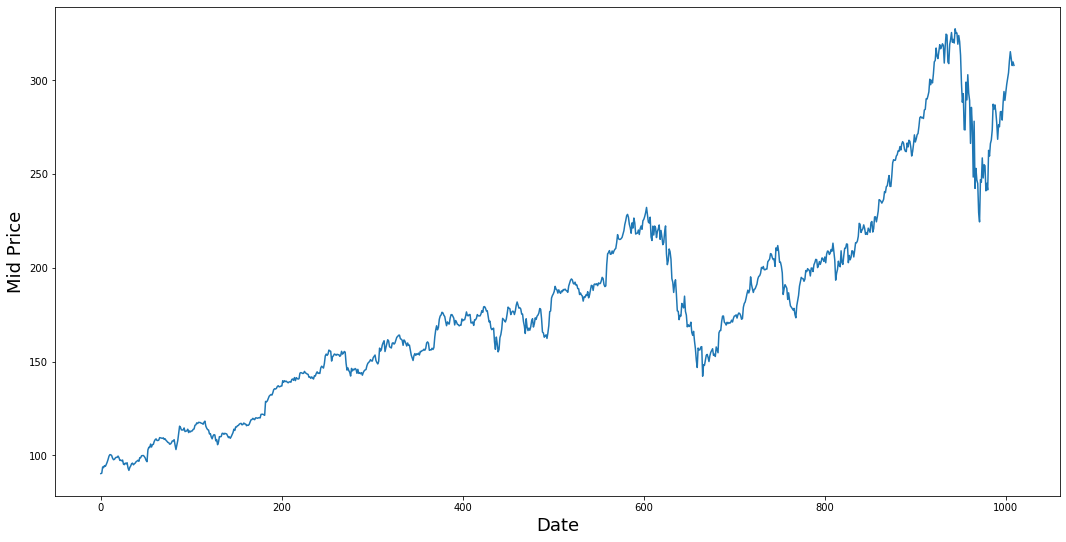

In [7]:
plt.figure(figsize = (18,9))
plt.plot(range(aapl.shape[0]), aapl['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

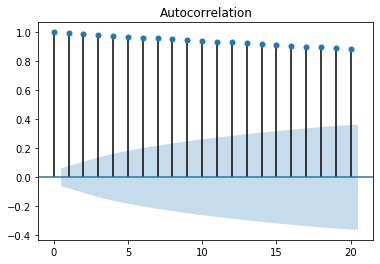

In [8]:
plot_acf(aapl, lags=20);


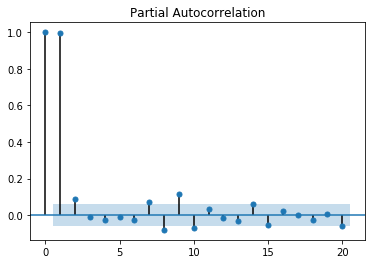

In [9]:
plot_pacf(aapl,lags=20);

Acording the graphs above, we can know that it is an **AR(1)** Process.

### Test for Stationary (ADF- Augmented Dickey-Fuller)

In [10]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


In [11]:
#apply adf test on the series
adf_test(aapl.close)

Results of Dickey-Fuller Test:
Test Statistic                  -0.699615
p-value                          0.846849
#Lags Used                      18.000000
Number of Observations Used    991.000000
Critical Value (1%)             -3.436966
Critical Value (5%)             -2.864461
Critical Value (10%)            -2.568325
dtype: float64


Since the p-value of ADF test is 0.84, which is larger than significant value.

It is not Stationary.

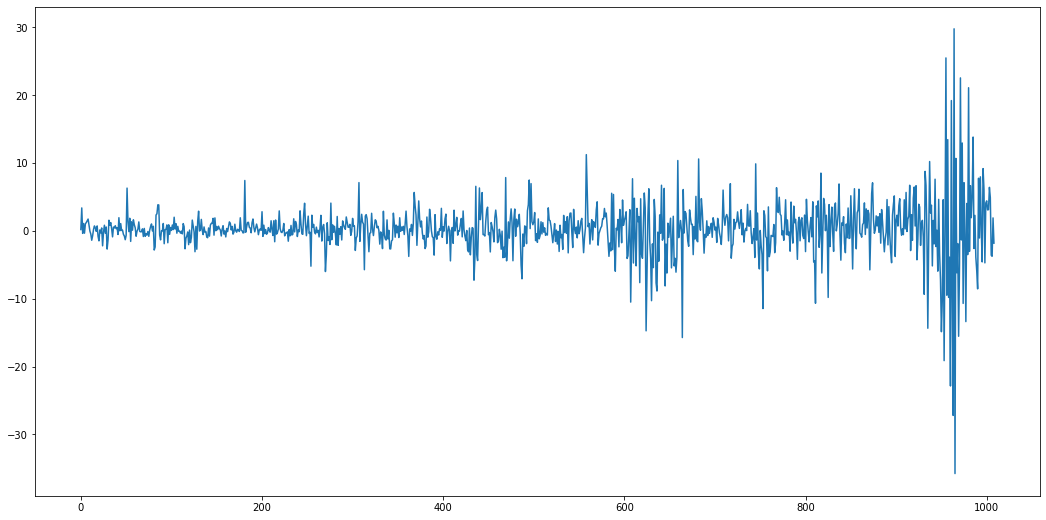

In [12]:
X = aapl.close
d1 = list()
for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    d1.append(value)
    
# plt.subplot(3,1,1)
plt.figure(figsize = (18,9))
plt.plot(d1) 
# plt.show()
# plt.show()
# plot_pacf(d1,lags=20) 
# plt.show()

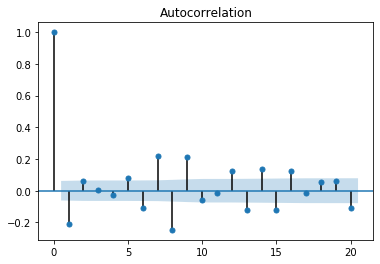

In [13]:
plot_acf(d1,lags=20);

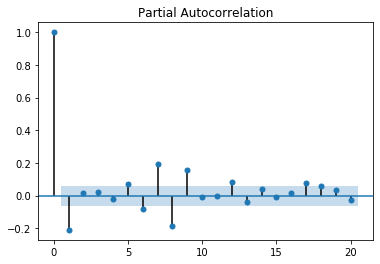

In [14]:
plot_pacf(d1,lags=20);

In [15]:
adf_test(d1)

Results of Dickey-Fuller Test:
Test Statistic                  -5.585103
p-value                          0.000001
#Lags Used                      17.000000
Number of Observations Used    991.000000
Critical Value (1%)             -3.436966
Critical Value (5%)             -2.864461
Critical Value (10%)            -2.568325
dtype: float64


We get rid of trend after differencing one time.

Double check by doing ADF test again.

In [16]:
X = aapl.close
train_size = int(len(X) * 0.8)
train, test = aapl.close[1:train_size], aapl.close[train_size:]

In [17]:

model = pm.auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=20,
                           start_P=0, seasonal=True,
                           d=1, D=None, trace=True,
                           error_action='warn',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.summary())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 20); AIC=3803.497, BIC=3826.957, Fit time=2.053 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 20); AIC=3800.161, BIC=3809.545, Fit time=0.017 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 20); AIC=3803.119, BIC=3821.888, Fit time=0.614 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 20); AIC=3803.180, BIC=3821.949, Fit time=0.752 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 20); AIC=3801.331, BIC=3815.407, Fit time=0.406 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 20); AIC=3801.404, BIC=3815.481, Fit time=0.440 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 20); AIC=3801.853, BIC=3820.621, Fit time=1.194 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 20); AIC=3802.001, BIC=3816.077, Fit time=0.058 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 20); AIC=3801.987, BIC=3816.064, Fit time=0.077 seconds
Fit ARIMA: order=(1, 1, 1) s

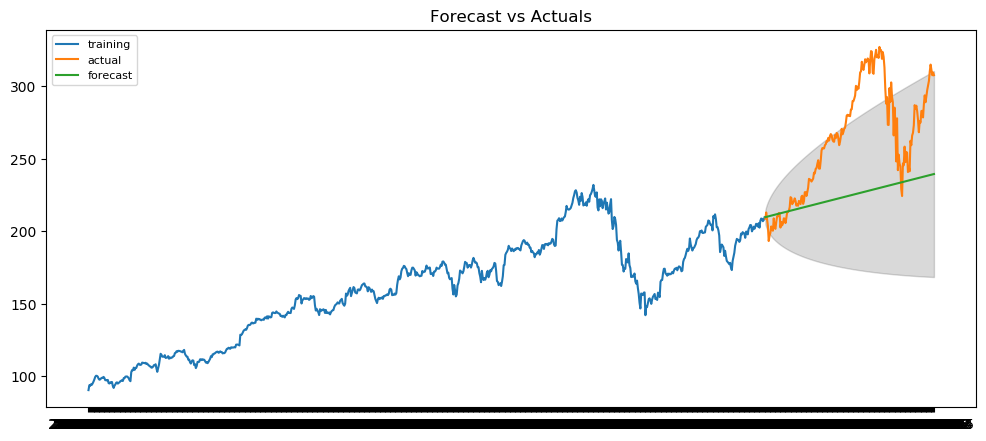

In [18]:
fitted = model.fit(train)
fc, conf = fitted.predict(len(test),return_conf_int=True,alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

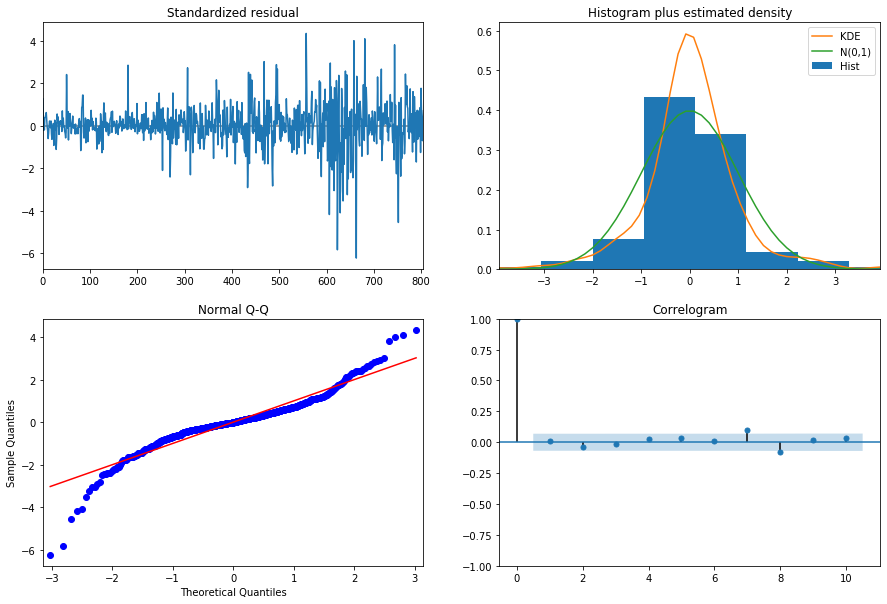

In [26]:
model.plot_diagnostics(figsize=(15,10))
plt.show()

The mean of residual is around zero.

But the residual is not perfectly normally distributed.

In [29]:
#if we select model based on train directly
model2 = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=20,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model2.summary())

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=3800.161, BIC=3809.545, Fit time=0.002 seconds
Fit ARIMA: order=(1, 1, 0); AIC=3802.001, BIC=3816.077, Fit time=0.016 seconds
Fit ARIMA: order=(0, 1, 1); AIC=3801.987, BIC=3816.064, Fit time=0.013 seconds
Total fit time: 0.110 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  806
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1898.081
Method:                           css   S.D. of innovations              2.550
Date:                Thu, 28 May 2020   AIC                           3800.161
Time:                        19:08:59   BIC                           3809.545
Sample:                             1   HQIC                          3803.765
                                                                              
                 coef    std err  

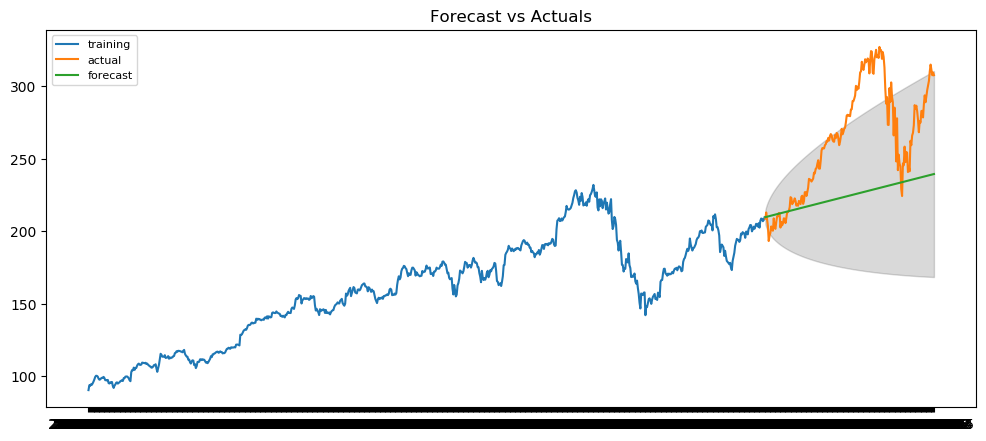

In [30]:

fitted2 = model2.fit(train)
fc2, conf2 = fitted2.predict(len(test),return_conf_int=True,alpha=0.05)
fc_series2 = pd.Series(fc2, index=test.index)
lower_series = pd.Series(conf2[:, 0], index=test.index)
upper_series = pd.Series(conf2[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series2, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

C:\Users\Kirsten\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Kirsten\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Kirsten\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Kirsten\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will b

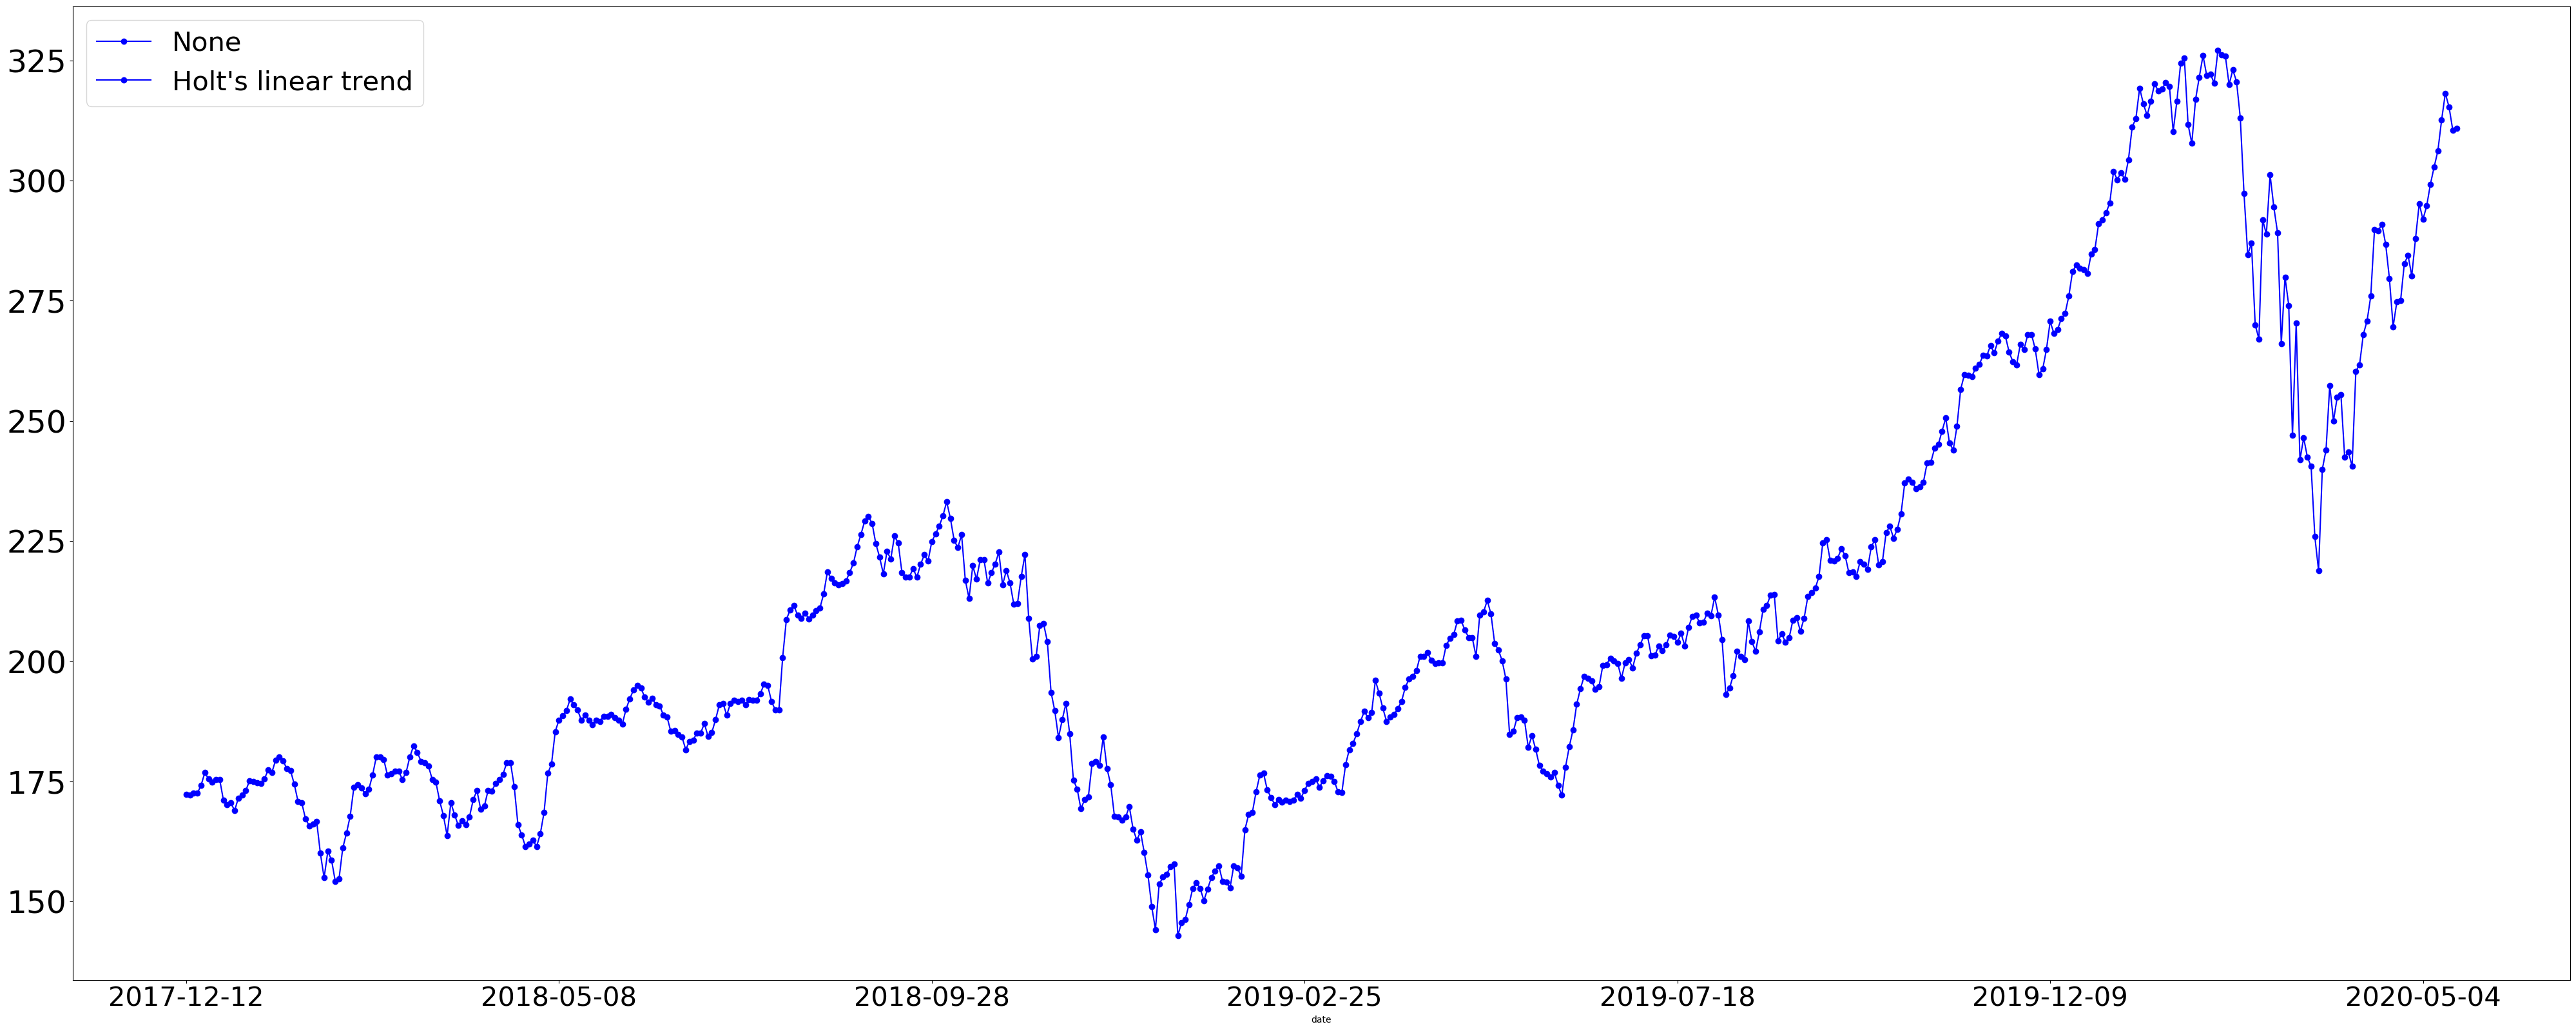

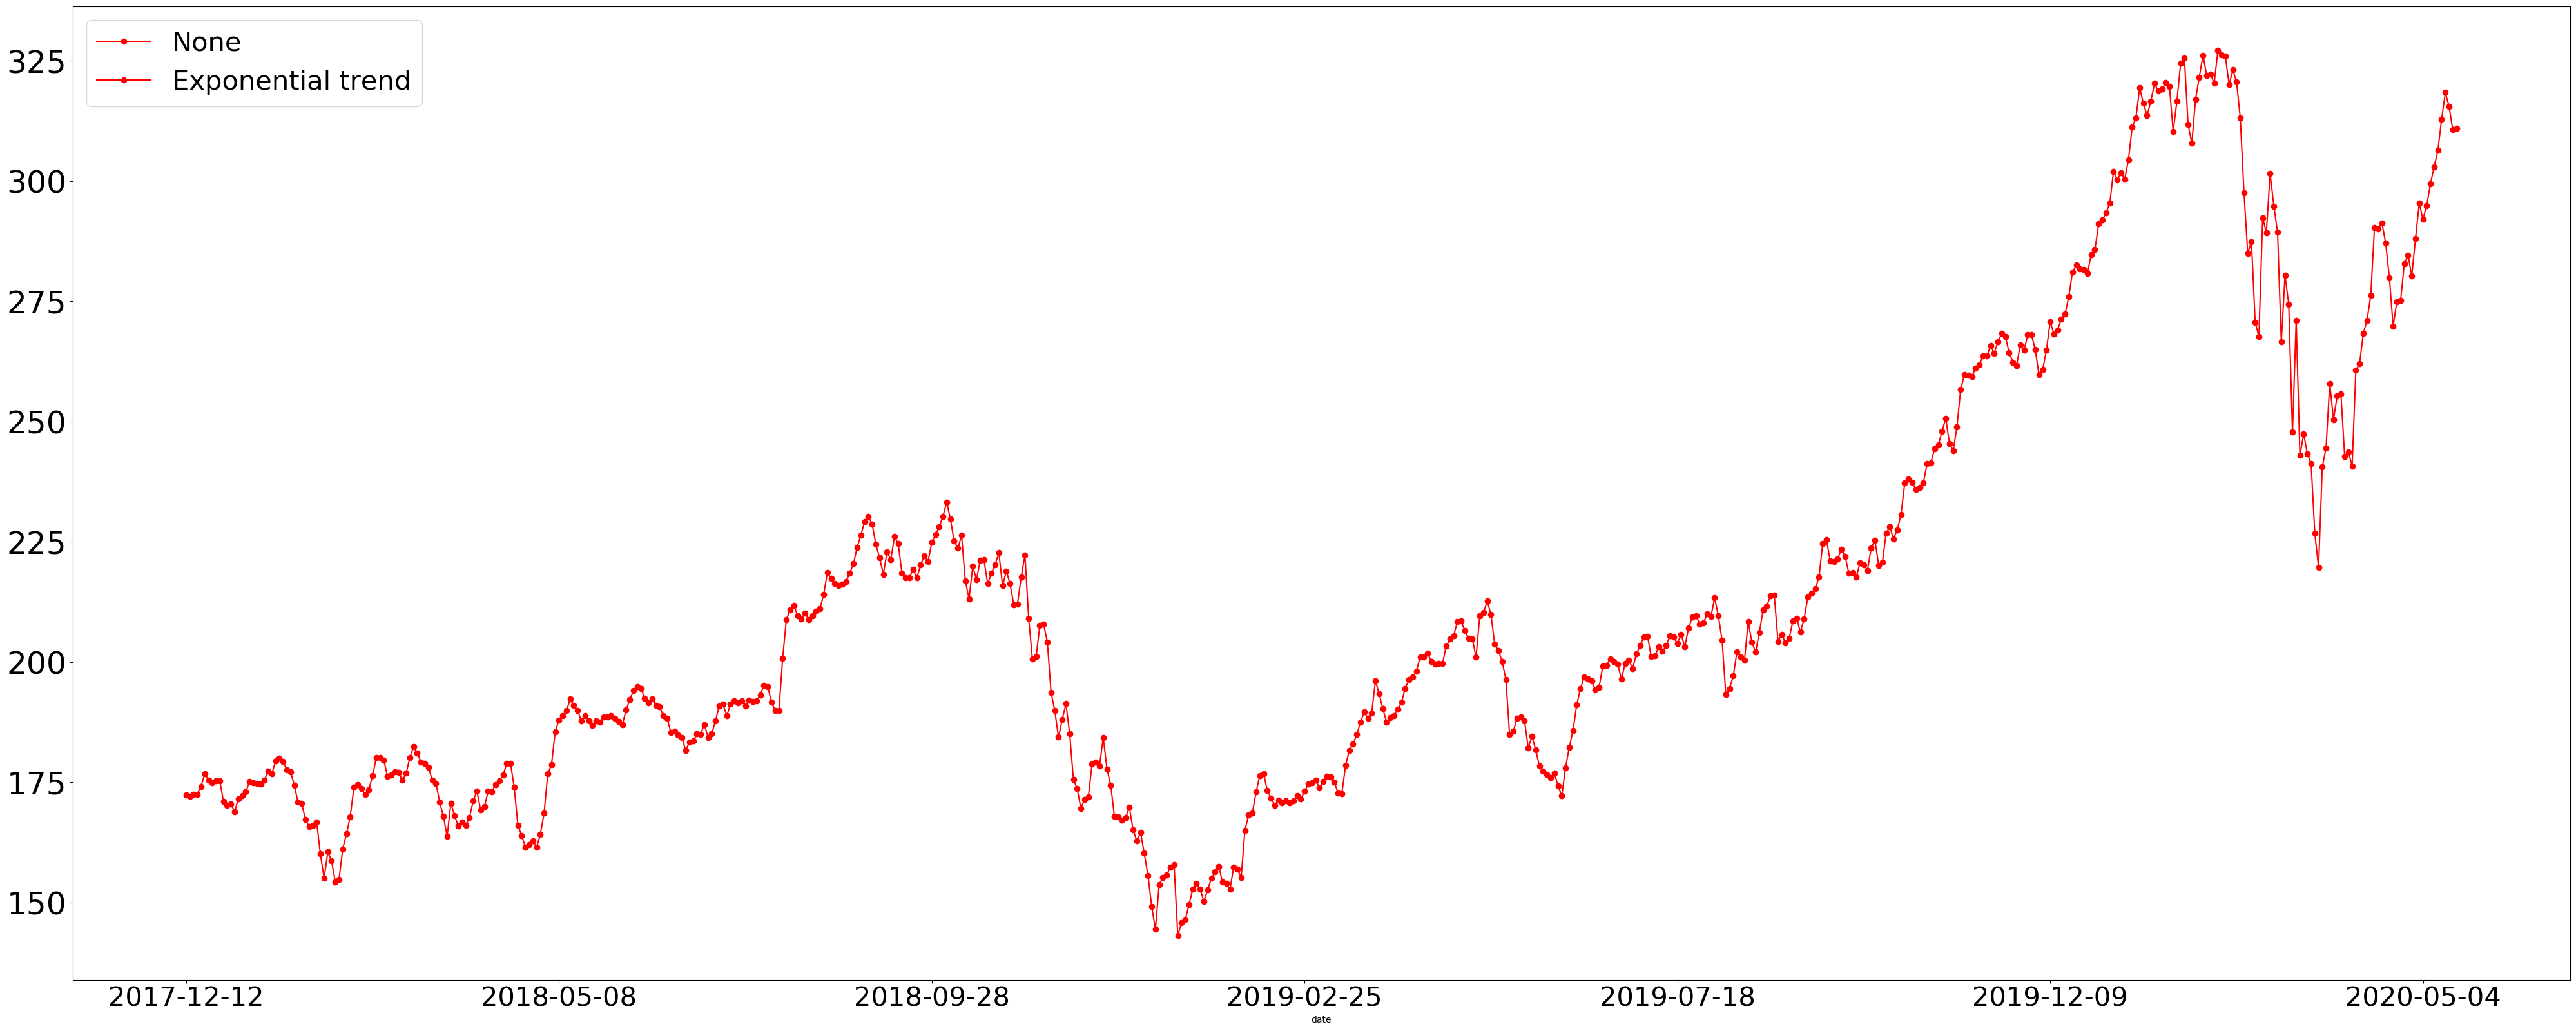

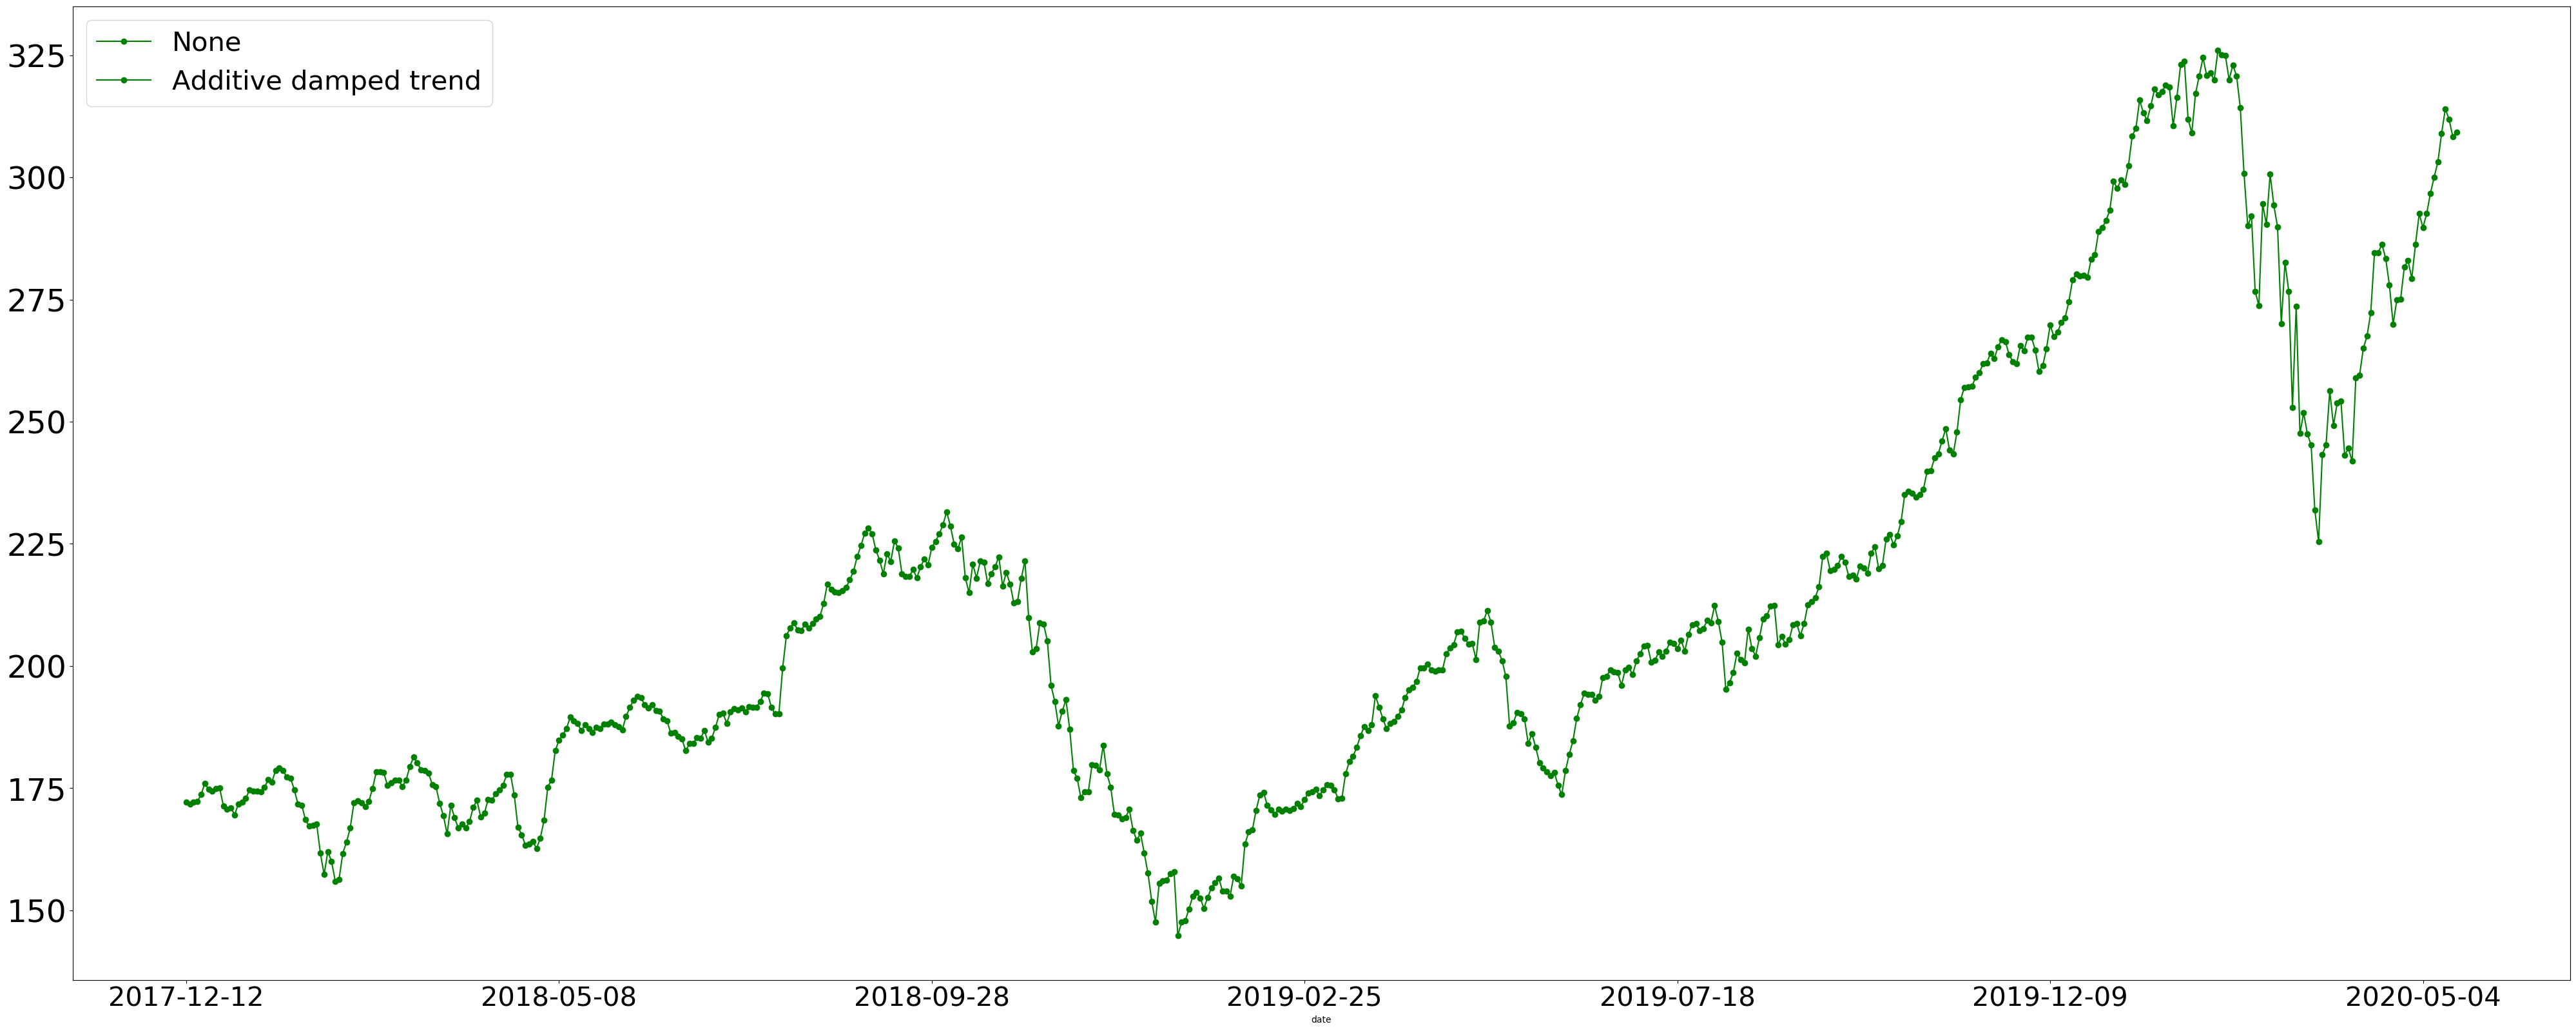

In [32]:
plt.figure(figsize=(50,20), dpi=100)
fit1 = Holt(aapl.close).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")

fit2 = Holt(aapl.close, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast2 = fit2.forecast(12).rename("Exponential trend")

fit3 = Holt(aapl.close, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3 = fit3.forecast(12).rename("Additive damped trend")


fit1.fittedvalues[400:].plot(marker="o", color='blue')
fcast1[400:].plot(color='blue', marker="o", legend=True)
plt.legend(loc=2, prop={'size': 30})
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=35)
plt.show()

plt.figure(figsize=(50,20), dpi=100)
fit2.fittedvalues[400:].plot(marker="o", color='red')
fcast2[400:].plot(color='red', marker="o", legend=True)
plt.legend(loc=2, prop={'size': 30})
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=35)
plt.show()

plt.figure(figsize=(50,20), dpi=100)
fit3.fittedvalues[400:].plot(marker="o", color='green')
fcast3[400:].plot(color='green', marker="o", legend=True)
plt.legend(loc=2, prop={'size': 30})
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=35)
plt.show()